In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import sys
from PIL import Image
from sys import stdout
import scipy
import scipy.misc

# from pylearn2.expr.preprocessing import global_contrast_normalize
def global_contrast_normalize(filename, s, lmda, epsilon):
    X = np.array(Image.open(filename))

    # replacement for the loop
    X_average = np.mean(X)
    print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = np.sqrt(lmda + np.mean(X**2))

    X = s * X / max(contrast, epsilon)

    # scipy can handle it
    scipy.misc.imsave('result.jpg', X)

# from pylearn2.datasets.preprocessing import ZCA
class ZCA:
    def __init__(self, transformation_matrix, transformation_mean):
        if transformation_matrix.size(0) != transformation_matrix.size(1):
            raise ValueError("transformation_matrix should be square. Got " +
                             "[{} x {}] rectangular matrix.".format(*transformation_matrix.size()))
        self.transformation_matrix = transformation_matrix
        self.transformation_mean = transformation_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (N, C, H, W) to be whitened.
        Returns:
            Tensor: Transformed image.
        """
        if tensor.size(1) * tensor.size(2) * tensor.size(3) != self.transformation_matrix.size(0):
            raise ValueError("tensor and transformation matrix have incompatible shape." +
                             "[{} x {} x {}] != ".format(*tensor[0].size()) +
                             "{}".format(self.transformation_matrix.size(0)))
        batch = tensor.size(0)

        flat_tensor = tensor.view(batch, -1)
        transformed_tensor = torch.mm(flat_tensor - self.transformation_mean, self.transformation_matrix)

        tensor = transformed_tensor.view(tensor.size())
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += (str(self.transformation_matrix.numpy().tolist()) + ')')
        return format_string


/Users/timgianitsos/Git/Model-Inversion-Attack/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/timgianitsos/Git/Model-Inversion-Attack/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/timgianitsos/Git/Model-Inversion-Attack/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

def face_imshow(img):
    plt.imshow(img.reshape([112,92]), cmap="gray")
    plt.axis('off')   
    

def one_hot_preds(preds):
    t = np.argmax(preds, axis=1)
    r = np.zeros(preds.shape)
    for i in range(t.shape[0]):
        r[i,t[i]] = 1
    return r

def one_hot_class(a):
    b = np.zeros((len(a), np.max(a).astype(int)+1), np.float32)
    b[np.arange(len(a)), a.astype(int)] = 1
    return b

def unpack_facedataset(path = os.path.join(os.extsep, os.path.abspath(''), 'faces'), sz=None):
    
    """Reads the images in a given folder, resizes images on the fly if size is given.

    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes 

    Returns:
        A list [X,y]

            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    
    c = 0
    X,y = [], []
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path, filename))
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
                except IOError as err:
                    print ("I/O error({0}): {1}".format(err))
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
    X = (np.array(X).astype(np.float32)/255).reshape(len(X), 92*112)
    y = np.array(y).astype(np.float32)
    X = X.reshape(40,10,112*92)
    y = y.reshape(40,10)

    train_x, test_x = X[:,0:7,:], X[:,7:10,:]
    train_y, test_y = y[:,0:7], y[:,7:10]
    train_x, test_x, train_y, test_y = train_x.reshape(40*7,112*92), test_x.reshape(40*3,112*92), train_y.reshape(40*7), test_y.reshape(40*3)
    
    return train_x, test_x, one_hot_class(train_y), one_hot_class(test_y)

def normalize(img, prep, img_shape):
    
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    img = global_contrast_normalize(img.reshape(1, -1) * 255, scale=55.)
    img = prep._gpu_matrix_dot(img - prep.mean_, prep.P_)
    return img.reshape(img_shape)

def post_process(img, prep, img_shape):
    # normalize without contrast_normalize and mean_subtract
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    return img.reshape(img_shape)


In [4]:
class Model:
    def __init__(self, x, y_):

        in_dim = int(x.get_shape()[1]) # 10304 for Face dataset
        out_dim = int(y_.get_shape()[1]) # 40 for Face dataset
        self.x = x
        # switiching to a simple 2-layer network with relu
        W = weight_variable([in_dim,out_dim])
        b = bias_variable([out_dim])
        self.y = tf.matmul(x,W) + b # output layer
        self.probs = tf.nn.softmax(self.y)
        self.class_inds = tf.argmax(self.probs,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=self.y))
        
        class_ind_correct = tf.argmax(y_,1)
        self.class_prob = (self.probs[0, tf.cast(class_ind_correct[0],tf.int32)])
        self.loss = tf.subtract(tf.constant(1.0), self.class_prob )
        
        self.grads = tf.gradients(self.cross_entropy, x)
        
        self.train_step = tf.train.GradientDescentOptimizer(0.1).minimize(self.cross_entropy)
        
        # performance metrics
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    
    def train(self, train_x, train_y, sess, test_x, test_y,num_iters, disp_freq=50):
        for i in range(num_iters):
            feed_dict = {x: train_x, y_: train_y}
            sess.run(self.train_step, feed_dict)
            if(i%disp_freq == 0):
                train_acc = self.test(train_x, train_y, sess)
                test_acc = self.test(test_x, test_y, sess)
                stdout.write("\r Train Acc. : %f    Test Acc. : %f"% (train_acc, test_acc))
                stdout.flush()
        stdout.write("\n")
            
    
    def test(self, test_x, test_y, sess):
        return (sess.run(self.accuracy, feed_dict={x: test_x, y_: test_y}))
    
    def invert(self, sess, num_iters, lam, img, pre_process, pred_cutoff= 0.99, disp_freq=1):
        
        probs = self.preds(img)
        class_ind = sess.run(self.class_inds, feed_dict= {x:[img]})[0]
        current_X = np.zeros(list(img.shape)[0]).astype(np.float32)
        Y = (one_hot_preds(probs)).astype(np.float32)
        best_X = np.copy(current_X)
        best_loss = 100000.0
        prev_losses = [100000.0]*100
        
        for i in range(num_iters):
            feed_dict = {x: [current_X], y_: Y }
            der,current_loss = sess.run([self.grads, self.loss], feed_dict)
            current_X = np.clip(current_X - lam*(der[0][0]),0.0,1.0)
            current_X = normalize(current_X, pre_process, current_X.shape)
            probs = self.preds(current_X)[0]
            
            if current_loss < best_loss:
                best_loss = current_loss
                best_X = current_X
            
            if current_loss > 2*max(prev_losses):
                print("\n Breaking due to gradient chaos!!")
                break
            
            if pred_cutoff < probs[class_ind]:
                print("\n Above Probability Criteria!: {0}".format(probs[class_ind]))
                break
                
            if i%disp_freq ==0:
#                 plt.close()
#                 face_imshow(post_process(current_X, pre_process, current_X.shape))
#                 plt.show()
                stdout.write("\r Acc: %f and Loss: %f and Best Loss: %f" % (probs[class_ind], current_loss, best_loss))
                stdout.flush()
            
            
        stdout.write("\n")   
        print('Loop Escape.')
        
        current_preds = self.preds(current_X)
        best_preds = self.preds(best_X)
        current_X = post_process(current_X, pre_process, current_X.shape)
        best_X = post_process(best_X, pre_process, best_X.shape)
        return current_X, current_preds, best_X, best_preds

    
    def preds(self, img):
        return sess.run(self.probs, feed_dict= {x:[img]})

def perform_inversion(pre_process, images):
        for img in images:
            face_imshow(img)
            plt.title('Image-Class used for inversion.')
            plt.show()
            print('Predictions: ' + str((model.preds(img))))


            inv_img_last, inv_img_last_p, inv_img_best, inv_img_best_p = model.invert(sess, 100, 0.1, img, pre_process = pre_process)

            face_imshow(inv_img_best)
            plt.title('Best Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_best_p))
            
            face_imshow(inv_img_last)
            plt.title('Last Iteration Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_last_p))

In [5]:
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 

# GCN and ZCA object!! 
train_x_normalized = global_contrast_normalize(train_x * 255, scale=55.)
zca = ZCA()
zca.fit(train_x_normalized)

TypeError: global_contrast_normalize() got an unexpected keyword argument 'scale'

In [87]:
x = tf.placeholder(tf.float32, shape=[None, 112*92])
y_ = tf.placeholder(tf.float32, shape=[None, 40])
model = Model(x,y_)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
model.train(train_x, train_y, sess, test_x, test_y, 250)

 Train Acc. : 1.000000    Test Acc. : 0.950000


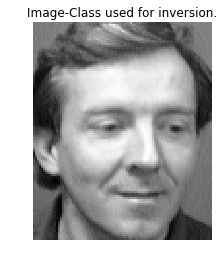

Predictions: [[9.6186727e-01 8.9160650e-04 5.0968683e-04 9.4819465e-05 1.2295325e-04
  8.3364255e-04 5.6160969e-04 2.1705457e-03 5.3993566e-04 7.3261093e-05
  1.5308143e-04 5.0771022e-03 1.7999168e-04 9.9314326e-05 5.3130597e-04
  3.2523337e-03 7.0569926e-04 5.0845225e-03 1.1119379e-04 3.6973000e-04
  3.0384228e-05 5.9488579e-05 6.1549807e-05 1.7529193e-04 9.5841923e-04
  4.7669946e-05 6.0285610e-04 3.0562726e-03 2.8007791e-05 2.1178227e-04
  3.1002008e-03 3.9824471e-04 1.2149358e-03 1.0971896e-03 4.7438322e-03
  4.4044751e-05 1.5862417e-05 5.2106014e-04 3.9555840e-04 7.5423077e-06]]
 Acc: 0.780279 and Loss: 0.219348 and Best Loss: 0.018958
Loop Escape.


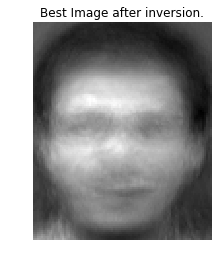

Predictions: [[8.48070323e-01 1.83040145e-04 8.26251402e-04 4.84882062e-03
  8.99282563e-03 1.94834005e-02 5.74863880e-05 4.50945646e-03
  3.90641345e-03 1.07725944e-04 1.34098425e-03 2.70169287e-04
  1.19447976e-03 8.46857112e-03 3.19131614e-05 1.22810248e-04
  1.61444885e-04 5.68191404e-04 5.27372351e-03 1.89813133e-02
  8.97535938e-06 4.18467716e-05 1.01831474e-05 7.69841427e-05
  1.19075715e-03 1.30150956e-03 1.33932326e-05 4.29100401e-05
  1.05255560e-04 9.98464134e-03 7.09668850e-04 6.00086823e-05
  5.80204511e-03 1.23550213e-04 5.03631728e-03 6.67858403e-03
  3.56311910e-02 3.55978729e-03 2.15836242e-03 6.47963025e-05]]


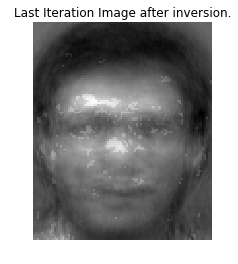

Predictions: [[7.80279458e-01 1.45823555e-03 4.48816834e-04 6.23594550e-03
  6.73397072e-03 4.12229635e-02 1.69641891e-04 8.19921610e-04
  7.86366221e-03 4.43777331e-04 3.89155728e-04 2.48965737e-03
  3.48211703e-04 2.06114165e-02 5.32280933e-03 1.01521355e-03
  2.97601626e-04 1.99194602e-03 5.26485220e-03 1.30725615e-02
  1.60991494e-05 1.51777256e-03 1.63575096e-05 6.98151707e-05
  6.23044383e-04 5.60059038e-04 4.01743251e-04 1.24905375e-03
  7.45704339e-04 5.52951880e-02 4.39663767e-04 3.25620029e-04
  1.13598322e-02 9.72969574e-04 6.67311251e-03 6.21573487e-03
  7.32892146e-03 4.97912196e-03 4.56376234e-03 1.66714410e-04]]


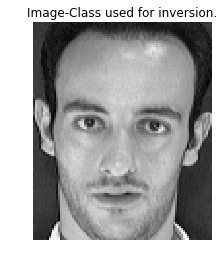

Predictions: [[7.30976753e-05 8.98442268e-01 2.59025884e-03 3.30395487e-05
  5.99460350e-03 1.13718306e-04 9.63318889e-05 9.49211972e-05
  7.58196547e-05 2.15914403e-03 6.45723892e-04 5.67093142e-04
  5.15461026e-04 4.55698668e-04 2.55959196e-04 6.67475513e-04
  8.31075304e-05 3.08035146e-06 1.75295339e-04 5.64462447e-04
  6.96892515e-02 1.42265882e-04 8.47191259e-04 1.33609474e-02
  8.66476548e-05 2.49416298e-05 1.50558917e-04 6.47784327e-05
  1.98915077e-04 2.26186057e-06 1.16605515e-04 1.46371473e-04
  7.06749197e-05 1.82905016e-04 1.16024530e-05 2.37498491e-04
  7.30773900e-04 1.51103653e-04 3.26636909e-05 1.45297789e-04]]
 Acc: 0.795052 and Loss: 0.206251 and Best Loss: 0.163688
Loop Escape.


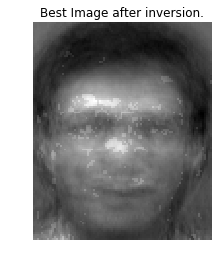

Predictions: [[3.64652253e-03 8.36239100e-01 1.85445824e-04 2.91622500e-03
  9.92486603e-04 3.89743634e-02 1.36027462e-04 1.40295329e-03
  1.47144042e-03 1.95950721e-04 1.28852960e-04 5.34150167e-04
  1.82969918e-04 1.21125495e-02 4.73296532e-04 6.52373477e-04
  2.41220361e-04 1.32595061e-03 9.44355968e-04 3.69111868e-03
  1.32050272e-05 1.10081735e-03 6.00449221e-06 1.31749257e-05
  8.41280387e-04 6.58502613e-05 4.41039068e-04 6.99395838e-04
  1.39727513e-03 6.62740171e-02 4.59693139e-04 1.54420617e-04
  2.03708257e-03 1.02198368e-03 1.97069929e-03 3.98792326e-03
  5.28282207e-03 3.81401344e-03 3.85628245e-03 1.15579627e-04]]


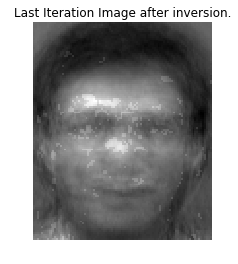

Predictions: [[5.1289285e-03 7.9505247e-01 1.8979922e-04 3.1020194e-03 1.4982186e-03
  6.0903467e-02 1.6957364e-04 1.8739927e-03 2.2338715e-03 2.1076367e-04
  1.3335806e-04 6.9222634e-04 2.5072641e-04 1.9959120e-02 3.5675400e-04
  7.7602942e-04 3.4206340e-04 1.4868316e-03 9.6724700e-04 5.2500116e-03
  1.8935256e-05 1.8489296e-03 7.1030381e-06 1.6400278e-05 1.0992859e-03
  6.6251327e-05 5.9245917e-04 9.7206299e-04 1.9014064e-03 6.2703140e-02
  5.5379007e-04 1.5761175e-04 1.4682165e-03 1.4965936e-03 1.9780486e-03
  3.2588132e-03 6.2780865e-03 6.1301314e-03 8.7115597e-03 1.6365742e-04]]


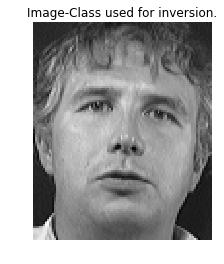

Predictions: [[4.6542114e-05 9.3005435e-04 9.4548887e-01 9.2451408e-04 2.6781275e-03
  6.6528009e-05 5.3296713e-05 2.5483110e-05 1.4801172e-04 3.0880033e-03
  2.0058152e-04 1.7511589e-04 1.7207836e-03 3.7492984e-05 1.7085343e-04
  1.2367956e-05 1.0934556e-04 1.6237065e-04 1.1359523e-03 3.5630160e-03
  4.6552457e-03 5.7963545e-05 5.2498085e-03 4.2975205e-03 4.3081917e-04
  1.3371259e-03 5.1834457e-05 6.4448759e-05 7.7291584e-04 4.8395308e-05
  9.3220107e-05 3.2604062e-03 8.7872853e-05 6.3347031e-04 1.2803153e-04
  3.9542071e-03 1.3232328e-03 1.2181883e-02 1.2157666e-05 6.2222086e-04]]
 Acc: 0.760800 and Loss: 0.239507 and Best Loss: 0.217075
Loop Escape.


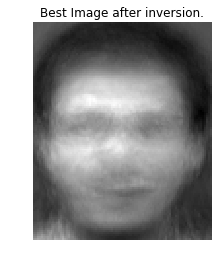

Predictions: [[4.69666943e-02 6.69498404e-04 4.56357628e-01 1.76056307e-02
  2.92670336e-02 6.45726547e-02 1.84962628e-04 1.51447486e-02
  1.41179590e-02 3.36435187e-04 5.60319936e-03 8.98375059e-04
  3.73651902e-03 2.55372655e-02 1.11918831e-04 3.85199935e-04
  5.53324760e-04 1.71597989e-03 1.95753034e-02 6.21562935e-02
  2.88197953e-05 1.60662836e-04 3.28071910e-05 2.12797415e-04
  3.88079486e-03 3.89307016e-03 4.34272079e-05 1.45429163e-04
  4.09365282e-04 3.42568457e-02 2.50044116e-03 2.46389478e-04
  1.99332032e-02 3.85812426e-04 1.72578953e-02 2.02785805e-02
  1.11193806e-01 1.17322579e-02 7.66664883e-03 2.44332477e-04]]


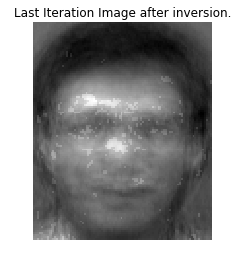

Predictions: [[1.1338479e-03 9.4169407e-04 7.6080024e-01 2.1829898e-03 3.1298646e-03
  7.9168141e-02 4.3747303e-04 2.3844182e-03 6.3423179e-03 1.6613076e-04
  1.5410988e-03 1.9622820e-03 8.6336411e-05 1.6866045e-02 2.4565302e-03
  3.0703275e-04 9.4532070e-04 3.1414661e-03 1.6793426e-02 5.0546853e-03
  1.0742746e-05 1.4342075e-03 3.8194667e-05 2.2461943e-05 1.2427287e-03
  1.9275460e-04 3.5282611e-04 3.4354406e-04 9.3763421e-04 4.7980331e-02
  2.5232459e-04 1.7233993e-04 1.2222135e-02 2.3319749e-03 6.0080108e-03
  2.6909003e-03 9.0115694e-03 5.9234230e-03 2.8460086e-03 1.4455731e-04]]


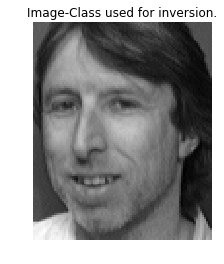

Predictions: [[1.2256796e-04 8.5394422e-04 6.0598198e-02 8.9349115e-01 7.2576324e-05
  1.8021590e-03 1.0913976e-03 6.8033597e-04 3.0239299e-04 1.6626850e-04
  1.0750330e-05 2.0090670e-04 7.8614130e-06 1.3043030e-05 9.5981779e-04
  1.2500632e-05 4.9238715e-05 1.1693453e-04 1.8890733e-03 4.4010702e-04
  1.3289675e-04 8.0873183e-04 1.7655038e-04 5.9254025e-06 7.1238442e-03
  1.2034151e-03 4.7139315e-06 1.4470097e-03 2.8658747e-03 9.7555159e-05
  9.1219636e-06 2.8552678e-05 7.0893875e-05 1.2937290e-04 6.1093306e-05
  1.2857415e-02 5.0023231e-03 4.9231297e-05 7.4463233e-04 4.2996895e-03]]
 Acc: 0.826358 and Loss: 0.174841 and Best Loss: 0.053830

KeyboardInterrupt: 

In [89]:
perform_inversion(zca, test_x[0::3])

In [8]:
"""
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 
zca = ZCA()
zca.fit(train_x[:2])
img = train_x[10]
img = normalize(img)
face_imshow(img,zca,img.shape)
"""

"""
from sys import stdout
from time import sleep
import numpy as np

a = np.array([10.2,.2,24.5,3,4,5,6,7,8,9,10,11])
for i in range(1,10):
    stdout.write("\r Hye there %d hi deer %d " % (a,i))
    stdout.flush()
    sleep(.25)
stdout.write("\n") # move the cursor to the next line

"""

'\nfrom sys import stdout\nfrom time import sleep\nimport numpy as np\n\na = np.array([10.2,.2,24.5,3,4,5,6,7,8,9,10,11])\nfor i in range(1,10):\n    stdout.write("\r Hye there %d hi deer %d " % (a,i))\n    stdout.flush()\n    sleep(.25)\nstdout.write("\n") # move the cursor to the next line\n\n'